In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.transform import warp
from skimage.transform import ProjectiveTransform
import cv2


In [ ]:
#load data

training_file = '/content/drive/MyDrive/Colab Notebooks/Datasets/train.p'
validation_file='/content/drive/MyDrive/Colab Notebooks/Datasets/valid.p'
testing_file = '/content/drive/MyDrive/Colab Notebooks/Datasets/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
#sign_names = read_csv("/content/drive/MyDrive/Colab Notebooks/Datasets/sign_names.csv").values[:, 0]
    
X_train_orig, Y_train_orig = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test_orig, Y_test_orig = test['features'], test['labels']

In [ ]:
# expoling

# Number of training examples
n_train = X_train_orig.shape[0]
# Number of validation examples
n_validation = X_valid.shape[0]
# Number of testing examples.
n_test = X_test_orig.shape[0]
# What's the shape of an traffic sign image?
image_shape = X_train_orig[0].shape
# Unique classes/labels there are in the dataset.
classes, class_indices, class_counts  = np.unique(Y_train_orig, return_index=True, return_counts=True)
n_classes = len(class_counts)


print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [ ]:
## Data Augmentation

def rotate_image(image, max_angle =15):
    rotate_out = rotate(image, np.random.uniform(-max_angle, max_angle), mode='edge')
    return rotate_out

def translate_image(image, max_trans = 5, height=32, width=32):
    translate_x = max_trans*np.random.uniform() - max_trans/2
    translate_y = max_trans*np.random.uniform() - max_trans/2
    translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
    trans = cv2.warpAffine(image, translation_mat, (height,width))
    return trans
    
def projection_transform(image, max_warp=0.8, height=32, width=32):
    #Warp Location
    d = height * 0.3 * np.random.uniform(0,max_warp)
    
    #Warp co-ordinates
    tl_top = np.random.uniform(-d, d)     # Top left corner, top margin
    tl_left = np.random.uniform(-d, d)    # Top left corner, left margin
    bl_bottom = np.random.uniform(-d, d)  # Bottom left corner, bottom margin
    bl_left = np.random.uniform(-d, d)    # Bottom left corner, left margin
    tr_top = np.random.uniform(-d, d)     # Top right corner, top margin
    tr_right = np.random.uniform(-d, d)   # Top right corner, right margin
    br_bottom = np.random.uniform(-d, d)  # Bottom right corner, bottom margin
    br_right = np.random.uniform(-d, d)   # Bottom right corner, right margin
        
    ##Apply Projection
    transform = ProjectiveTransform()
    transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, height - bl_bottom),
                (height - br_right, height - br_bottom),
                (height - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, height),
                (height, height),
                (height, 0)
            )))
    output_image = warp(image, transform, output_shape=(height, width), order = 1, mode = 'edge')
    return output_image
    

def transform_image(image, max_angle=15, max_trans =5 ,max_warp=0.8):
    ## Simple pipline to take an input image and apply a serise of simple
    ## Distortions to augment the training data set
    ## (note: this function will rescale pixel values between 0-1)
    ##
    height, width, channels = image.shape
    #Rotate Image
    rotated_image = rotate_image(image, max_angle)
    #Translate Image
    translated_image = translate_image(rotated_image, max_trans, height, width)
    #Project Image
    output_image = projection_transform(translated_image, max_warp, height, width)
    return (output_image*255.0).astype(np.uint8)

    
def augment_and_balance_data(X_train, y_train, no_examples_per_class =10000):
    
    n_examples = no_examples_per_class
    #Get paramters of data
    classes, class_indices, class_counts  = np.unique(y_train, return_index=True, return_counts=True)
    height, width, channels = X_train[0].shape
    
    
    #Create new data and labels for the balanced augmented data
    X_balance = np.empty([0, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
    y_balance = np.empty([0], dtype = y_train.dtype)
    

    for c, count in zip(range(n_classes), class_counts):
        ##Copy over the current data for the given class
        X_orig = X_train[y_train == c]
        y_orig = y_train[y_train == c]
        ##Add original data to the new dataset
        X_balance = np.append(X_balance, X_orig, axis=0)
        print(c,count)
        temp_X = np.empty([n_examples-count, X_train.shape[1], X_train.shape[2], X_train.shape[3]], dtype = np.float32)
        for i in range(n_examples - count):
            temp_X[i,:,:,:] = transform_image(X_orig[i%count]).reshape((1, height, width, channels))
            
            
        X_balance = np.append(X_balance,temp_X, axis=0)
        n_added_ex = X_balance.shape[0] - y_balance.shape[0]
        y_balance = np.append(y_balance, np.full(n_added_ex, c, dtype =int))
        
   
    return X_balance.astype(np.uint8), y_balance


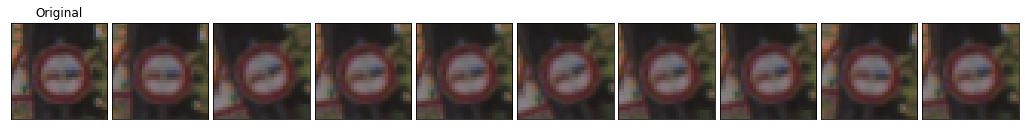

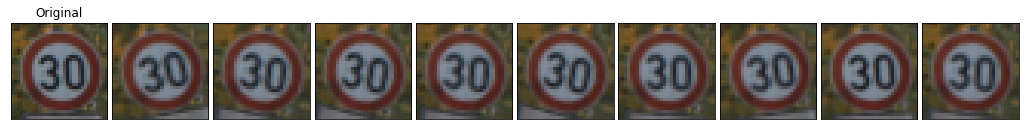

In [ ]:
### Example of Rotation

no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (14, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train_orig[image[j],:,:,:])
            axis.title.set_text('Original')
        else:    
            axis.imshow(rotate_image(X_train_orig[image[j],:,:,:], 20))
    pyplot.show()

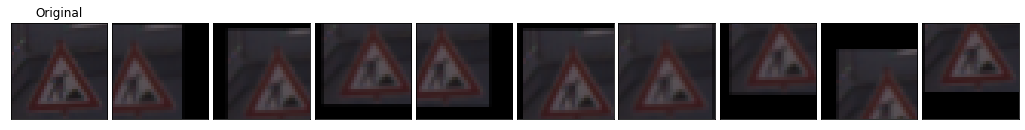

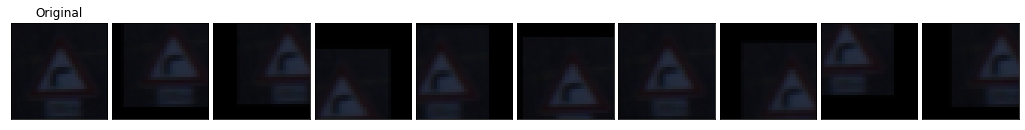

In [ ]:
### Example of Translation

no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (14, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train_orig[image[j],:,:,:])
            axis.title.set_text('Original')
        else:    
            axis.imshow(translate_image(X_train_orig[image[j],:,:,:], 20))
    pyplot.show()

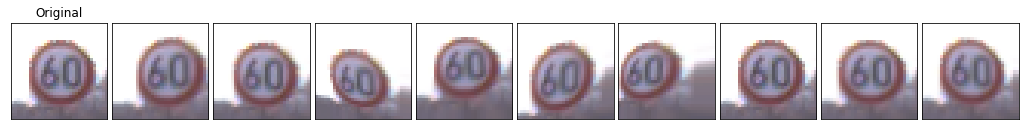

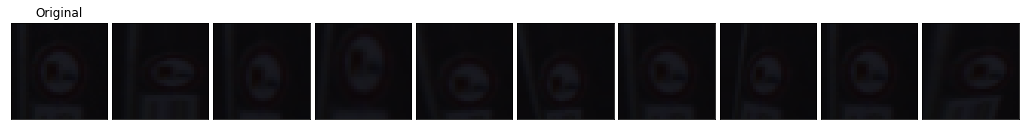

In [ ]:
### Example of Homography Projection

no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (14, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train_orig[image[j],:,:,:])
            axis.title.set_text('Original')
        else:    
            axis.imshow(projection_transform(X_train_orig[image[j],:,:,:]))
    pyplot.show()

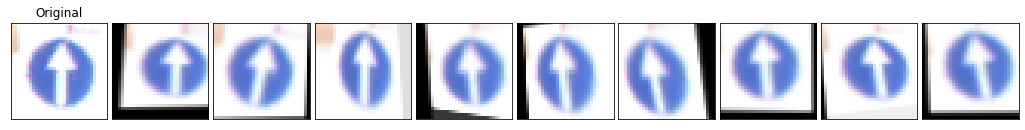

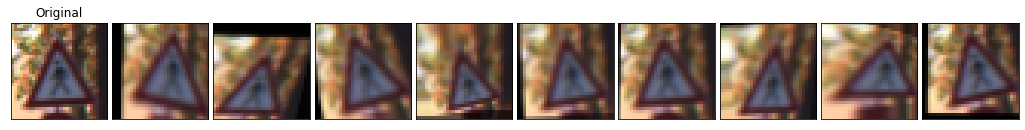

In [ ]:
### Example of Data Augmentation Pipeline

no_examples = 2
image = np.random.randint(0, n_train, no_examples)

for j in range(no_examples):
    fig = pyplot.figure(figsize = (14, 2))
    fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        if i == 0:
            axis.imshow(X_train_orig[image[j],:,:,:])
            axis.title.set_text('Original')
        else:    
            axis.imshow(transform_image(X_train_orig[image[j],:,:,:]))
    pyplot.show()

In [ ]:
####Only Run to generate Augmented data !!!!! (is LONG)
## Resulting saved data set will be around 1GB for 10000 examples each class

X_out, y_out = augment_and_balance_data(X_train_orig, Y_train_orig, 2100)
np.savez_compressed('/content/drive/MyDrive/Colab Notebooks/Datasets/augmentedData2100', X_train_aug = X_out, y_train_aug = y_out)

0 180
1 1980
2 2010
3 1260
4 1770
5 1650
6 360
7 1290
8 1260
9 1320
10 1800
11 1170
12 1890
13 1920
14 690
15 540
16 360
17 990
18 1080
19 180
20 300
21 270
22 330
23 450
24 240
25 1350
26 540
27 210
28 480
29 240
30 390
31 690
32 210
33 599
34 360
35 1080
36 330
37 180
38 1860
39 270
40 300
41 210
42 210


In [ ]:
##Load premade augmented data

loaded = np.load('AugTrafficdata.npz')
X_train_aug = loaded['X_train_aug']
y_train_aug = loaded['y_train_aug']
print("Augmented Dataset size X")
print(X_train_aug.shape)
print("Augmented Dataset size y")
print(y_train_aug.shape)

Augmented Dataset size X
(430000, 32, 32, 3)
Augmented Dataset size y
(430000,)
